In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.ndimage import gaussian_filter

def apply_filter_to_nifti_image(img_data):
    # Load the NIfTI image
    sigma = 1.0
    # Get the image data
    # Apply Gaussian filter to each slice
    filtered_slices = np.zeros_like(img_data)
    skull_stripped_slices = np.zeros_like(img_data)

    # Define the dimensions of the ROI
    roi_size = 244

    # Define CLAHE parameters
    clahe_slices = np.zeros_like(img_data)
    clip_limit = 0.8
    tile_grid_size = (8, 8)

    for i in range(img_data.shape[2]):  # Assuming the slice dimension is the third dimension
        filtered_slices[:, :, i] = gaussian_filter(img_data[:, :, i], 0.2)
        slice_data = filtered_slices[:, :, i]
        threshold_value=1
        # Check if slice is empty before skull stripping
            # If the slice is empty, skip skull stripping and store the original slice

            # Convert slice data to 8-bit unsigned integer format
        slice_data_uint8 = cv2.normalize(slice_data, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

        # Skull stripping
        gray = slice_data_uint8
        ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
        if ret > 0:

            colormask = np.zeros_like(slice_data_uint8, dtype=np.uint8)
            colormask[thresh != 0] = 255  # Set non-zero threshold values to 255
            colormask_bgr = cv2.cvtColor(colormask, cv2.COLOR_GRAY2BGR)  # Convert to BGR color format
            colormask_bgr[thresh == 0] = [0, 0, 0]  # Set background pixels to black
            blended = cv2.addWeighted(cv2.cvtColor(slice_data_uint8, cv2.COLOR_GRAY2BGR), 0.7, colormask_bgr, 0.1, 0)
            ret, markers = cv2.connectedComponents(thresh)

            # Get the area taken by each component. Ignore label 0 since this is the background.
            marker_area = [np.sum(markers == m) for m in range(1, np.max(markers) + 1)]

            # Set thresholds for minimum area and minimum brain content proportion

            if not marker_area:

                # If no brain area is detected, area is too small, or brain content proportion is too low,
                # skip skull stripping and use the original slice
                skull_stripped_slices[:, :, i] = filtered_slices[:, :, i]
                clahe_slices[:, :, i] = filtered_slices[:, :, i]  # Store the CLAHE enhanced slice
            else:
                largest_component = np.argmax(marker_area) + 1
                brain_mask = markers == largest_component
                brain_out = slice_data.copy()
                brain_out[brain_mask == False] = 0

                # Extract the central ROI of size 244x244
                center_x, center_y = np.array(brain_out.shape) // 2
                half_roi_size = roi_size // 2
                roi_start_x = max(0, center_x - half_roi_size)
                roi_end_x = min(brain_out.shape[0], center_x + half_roi_size)
                roi_start_y = max(0, center_y - half_roi_size)
                roi_end_y = min(brain_out.shape[1], center_y + half_roi_size)
                skull_stripped_roi = brain_out[roi_start_x:roi_end_x, roi_start_y:roi_end_y]

                # Append the skull-stripped ROI to the list
                skull_stripped_slices[:, :, i] = skull_stripped_roi
                slice_data_norm = cv2.normalize(skull_stripped_roi, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

                # Apply CLAHE to the slice
                clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
                clahe_slice = clahe.apply(slice_data_norm)
                # Store the CLAHE enhanced slice
                clahe_slices[:, :, i] = clahe_slice

# Example usage:
    return clahe_slices

In [ ]:
import tkinter as tk
from tkinter import filedialog
import os
import torch
import numpy as np
from monai.transforms import Compose, LoadImaged, ConvertToMultiChannelBasedOnBratsClassesd, NormalizeIntensityd
from monai.data import Dataset, DataLoader
from functools import partial
from monai.networks.nets import SwinUNETR
slice_num = 87  # تعيين رقم الشريحة
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)
from monai.transforms import Compose, LoadImaged, \
    CropForegroundd, RandSpatialCropd, RandFlipd, NormalizeIntensityd, RandScaleIntensityd, RandShiftIntensityd
import shutil  # استيراد وحدة التحكم بالملفات والمجلدات
from monai import data

import os
import gzip
import nibabel as nib
from monai.transforms import MapTransform
from monai.inferers import sliding_window_inference



import monai
import numpy as np
import pandas as pd

from typing import Union
from PIL import Image
from monai.utils import set_determinism
from monai.utils.enums import MetricReduction
from monai.transforms import (
    AsDiscrete,
    ScaleIntensityRangePercentilesd,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    MapTransform,
    Activations,
    Activationsd,
    Invertd,
    NormalizeIntensityd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    EnsureTyped,
    SpatialPadd,
    SaveImage,
    RandRotate90d,
    ConcatItemsd,
    DeleteItemsd,
)
from monai.networks.utils import one_hot
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,HausdorffDistanceMetric,ConfusionMatrixMetric, compute_hausdorff_distance, CumulativeIterationMetric
from monai.losses import DiceCELoss,DiceLoss, TverskyLoss
from monai.inferers import sliding_window_inference

from monai.data import PersistentDataset, list_data_collate, decollate_batch, DataLoader, load_decathlon_datalist, CacheDataset # NiftiSaver

from monai.config import print_config
from monai.apps import download_and_extract,DecathlonDataset
from monai.handlers.utils import from_engine

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import nibabel as nib





class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats 2023 classes:
    label 1 necrotic tumor core (NCR)
    label 2 peritumoral edematous/invaded tissue 
    label 4 is not used in the new dataset version
    label 3 GD-enhancing tumor 
    The possible classes are:
      TC (Tumor core): merge labels 1 and 3
      WT (Whole tumor): merge labels 1,2 and 3
      ET (Enhancing tumor): label 3

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 1 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 1, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 1, d[key] == 2), d[key] == 3
                )
            )
            # label 3 is ET
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).astype(np.float32)
        return d
def compress_nifti(input_file_path, output_file_path):
    # Load the NIfTI image
    img = nib.load(input_file_path)

    # Define the output file path with ".nii.gz" extension
    output_file_path = output_file_path + ".nii.gz"

    # Save the NIfTI image as a compressed NIfTI file
    with gzip.open(output_file_path, 'wb') as f:
        f.write(img.to_bytes())

def check_files(folder_path):
    expected_files = {'t2f.nii', 't2w.nii', 't1n.nii', 't1c.nii'}
    
    files_in_folder = set(os.listdir(folder_path))
    missing_files = expected_files - files_in_folder
    if missing_files:
        return False, missing_files
    else:
        # Compress the files to nii.gz format
        for file_name in expected_files:
            input_file_path = os.path.join(folder_path, file_name)
            output_file_path = os.path.join(folder_path, file_name.split('.')[0])
            compress_nifti(input_file_path, output_file_path)
        
        return True, None


def select_folder():
    folder_path = filedialog.askdirectory()
    if folder_path:
        is_valid, missing_files = check_files(folder_path)
        if is_valid:
            label.config(text="تم التحقق من وجود الملفات بنجاح.")
            # استخدم مسارات الملفات المحددة لتحميل الملفات لاحقًا
            test_files = [
                {
                    "image": [
                        os.path.join(folder_path, 't2f.nii.gz'),
                        os.path.join(folder_path, 't2w.nii.gz'),
                        os.path.join(folder_path, 't1n.nii.gz'),
                        os.path.join(folder_path, 't1c.nii.gz'),
                    ],
                }
            ]
            # استخدم المسارات المحددة لتحميل الملفات إلى النموذج
            test_transform = Compose([
                LoadImaged(keys=["image"]),
                NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
            ])
            test_ds = Dataset(data=test_files, transform=test_transform)
            test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=4, pin_memory=False)

            # تحميل النموذج المدرب مسبقًا
            roi = (128, 128, 128)
            print("ok1")
            model = SwinUNETR(
                img_size=roi,
                in_channels=4,
                out_channels=3,
                feature_size=48,
                drop_rate=0.0,
                attn_drop_rate=0.0,
                dropout_path_rate=0.0,
                use_checkpoint=True,
            )
            label.config(text="2")
            print("ok2")

            model.load_state_dict(torch.load(os.path.join(r"D:\proj\training\training1\0.85\model100.pt"), map_location=torch.device('cpu'))["state_dict"])
            model.eval()

            # تحديد دالة التنبؤ
            model_inferer_test = partial(
                sliding_window_inference,
                roi_size=[roi[0], roi[1], roi[2]],
                sw_batch_size=4,
                predictor=model,
                overlap=0.6,
            )

            with torch.no_grad():
                for batch_data in test_loader:
                    print("ok3")

                    image = batch_data["image"]
                    print("ok5")

                    prob = torch.sigmoid(model_inferer_test(image))
                    print("ok4")
                    seg = prob[0].detach().cpu().numpy()
                    seg = (seg > 0.5).astype(np.int8)
                    seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
                    seg_out[seg[1] == 1] = 2
                    seg_out[seg[0] == 1] = 1
                    seg_out[seg[2] == 1] = 4
                    print(seg_out.shape)  # إخراج شكل الورم
                    
                    # عرض الصورة والتسمية والتنبؤ
                    plt.figure("Brain Images", (18, 6))
                    plt.subplot(1, 3, 3)
                    plt.title("Segmentation")
                    plt.imshow(seg_out[:, :, slice_num])

                    plt.show()
        else:

# إنشاء نافذة رئيسية
root = tk.Tk()
root.title("برنامج تشخيص ورم دبقي للدماغ")

# إنشاء عنصر Label لعرض النص
label = tk.Label(root, text="الرجاء تحديد مجلد يحتوي على الملفات:")
label.pack(pady=10)

# إنشاء زر لتحديد المجلد
browse_button = tk.Button(root, text="تحديد المجلد", command=select_folder)
browse_button.pack(pady=5)

# تشغيل النافذة الرئيسية
root.mainloop()


In [4]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

2024-05-06 19:42:20.824079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 19:42:20.824179: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 19:42:20.953411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.39.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/i

In [1]:
pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from __future__ import annotations

import itertools
from collections.abc import Sequence

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.nn import LayerNorm
from typing_extensions import Final

from monai.networks.blocks import MLPBlock as Mlp
from monai.networks.blocks import PatchEmbed, UnetOutBlock, UnetrBasicBlock, UnetrUpBlock
from monai.networks.layers import DropPath, trunc_normal_
from monai.utils import ensure_tuple_rep, look_up_option, optional_import
from monai.utils.deprecate_utils import deprecated_arg

rearrange, _ = optional_import("einops", name="rearrange")

__all__ = [
    "SwinUNETR",
    "window_partition",
    "window_reverse",
    "WindowAttention",
    "SwinTransformerBlock",
    "PatchMerging",
    "PatchMergingV2",
    "MERGING_MODE",
    "BasicLayer",
    "SwinTransformer",
]




class SwinUNETR(nn.Module):
    """
    Swin UNETR based on: "Hatamizadeh et al.,
    Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images
    <https://arxiv.org/abs/2201.01266>"
    """

    patch_size: Final[int] = 2



    @deprecated_arg(
        name="img_size",
        since="1.3",
        removed="1.5",
        msg_suffix="The img_size argument is not required anymore and "
        "checks on the input size are run during forward().",
    )
    def __init__(
        self,
        img_size: Sequence[int] | int,
        in_channels: int,
        out_channels: int,
        depths: Sequence[int] = (2, 2, 2, 2),
        num_heads: Sequence[int] = (3, 6, 12, 24),
        feature_size: int = 24,
        norm_name: tuple | str = "instance",
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        dropout_path_rate: float = 0.0,
        normalize: bool = True,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            img_size: spatial dimension of input image.
                This argument is only used for checking that the input image size is divisible by the patch size.
                The tensor passed to forward() can have a dynamic shape as long as its spatial dimensions are divisible by 2**5.
                It will be removed in an upcoming version.
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            feature_size: dimension of network feature size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            norm_name: feature normalization type and arguments.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            dropout_path_rate: drop path rate.
            normalize: normalize output intermediate features in each stage.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: number of spatial dims.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beggining of each swin stage.

        Examples::

            # for 3D single channel input with size (96,96,96), 4-channel output and feature size of 48.
            >>> net = SwinUNETR(img_size=(96,96,96), in_channels=1, out_channels=4, feature_size=48)

            # for 3D 4-channel input with size (128,128,128), 3-channel output and (2,4,2,2) layers in each stage.
            >>> net = SwinUNETR(img_size=(128,128,128), in_channels=4, out_channels=3, depths=(2,4,2,2))

            # for 2D single channel input with size (96,96), 2-channel output and gradient checkpointing.
            >>> net = SwinUNETR(img_size=(96,96), in_channels=3, out_channels=2, use_checkpoint=True, spatial_dims=2)

        """

        super().__init__()

        img_size = ensure_tuple_rep(img_size, spatial_dims)
        patch_sizes = ensure_tuple_rep(self.patch_size, spatial_dims)
        window_size = ensure_tuple_rep(7, spatial_dims)

        if spatial_dims not in (2, 3):
            raise ValueError("spatial dimension should be 2 or 3.")

        self._check_input_size(img_size)

        if not (0 <= drop_rate <= 1):
            raise ValueError("dropout rate should be between 0 and 1.")

        if not (0 <= attn_drop_rate <= 1):
            raise ValueError("attention dropout rate should be between 0 and 1.")

        if not (0 <= dropout_path_rate <= 1):
            raise ValueError("drop path rate should be between 0 and 1.")

        if feature_size % 12 != 0:
            raise ValueError("feature_size should be divisible by 12.")

        self.normalize = normalize

        self.swinViT = SwinTransformer(
            in_chans=in_channels,
            embed_dim=feature_size,
            window_size=window_size,
            patch_size=patch_sizes,
            depths=depths,
            num_heads=num_heads,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=drop_rate,
            attn_drop_rate=attn_drop_rate,
            drop_path_rate=dropout_path_rate,
            norm_layer=nn.LayerNorm,
            use_checkpoint=use_checkpoint,
            spatial_dims=spatial_dims,
            downsample=look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample,
            use_v2=use_v2,
        )

        self.encoder1 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder2 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder3 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=2 * feature_size,
            out_channels=2 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder4 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=4 * feature_size,
            out_channels=4 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.encoder10 = UnetrBasicBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=16 * feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder5 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=16 * feature_size,
            out_channels=8 * feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder4 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder3 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.decoder1 = UnetrUpBlock(
            spatial_dims=spatial_dims,
            in_channels=feature_size,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=True,
        )

        self.out = UnetOutBlock(spatial_dims=spatial_dims, in_channels=feature_size, out_channels=out_channels)



    def load_from(self, weights):
        with torch.no_grad():
            self.swinViT.patch_embed.proj.weight.copy_(weights["state_dict"]["module.patch_embed.proj.weight"])
            self.swinViT.patch_embed.proj.bias.copy_(weights["state_dict"]["module.patch_embed.proj.bias"])
            for bname, block in self.swinViT.layers1[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers1")
            self.swinViT.layers1[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.reduction.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.weight"]
            )
            self.swinViT.layers1[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers1.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers2[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers2")
            self.swinViT.layers2[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.reduction.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.weight"]
            )
            self.swinViT.layers2[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers2.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers3[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers3")
            self.swinViT.layers3[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.reduction.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.weight"]
            )
            self.swinViT.layers3[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers3.0.downsample.norm.bias"]
            )
            for bname, block in self.swinViT.layers4[0].blocks.named_children():
                block.load_from(weights, n_block=bname, layer="layers4")
            self.swinViT.layers4[0].downsample.reduction.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.reduction.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.weight.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.weight"]
            )
            self.swinViT.layers4[0].downsample.norm.bias.copy_(
                weights["state_dict"]["module.layers4.0.downsample.norm.bias"]
            )

    @torch.jit.unused
    def _check_input_size(self, spatial_shape):
        img_size = np.array(spatial_shape)
        remainder = (img_size % np.power(self.patch_size, 5)) > 0
        if remainder.any():
            wrong_dims = (np.where(remainder)[0] + 2).tolist()
            raise ValueError(
                f"spatial dimensions {wrong_dims} of input image (spatial shape: {spatial_shape})"
                f" must be divisible by {self.patch_size}**5."
            )


    def forward(self, x_in):
        if not torch.jit.is_scripting():
            self._check_input_size(x_in.shape[2:])
        hidden_states_out = self.swinViT(x_in, self.normalize)
        enc0 = self.encoder1(x_in)
        enc1 = self.encoder2(hidden_states_out[0])
        enc2 = self.encoder3(hidden_states_out[1])
        enc3 = self.encoder4(hidden_states_out[2])
        dec4 = self.encoder10(hidden_states_out[4])
        dec3 = self.decoder5(dec4, hidden_states_out[3])
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        dec0 = self.decoder2(dec1, enc1)
        out = self.decoder1(dec0, enc0)
        logits = self.out(out)
        return logits





def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows


def window_reverse(windows, window_size, dims):
    """window reverse operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        windows: windows tensor.
        window_size: local window size.
        dims: dimension values.
    """
    if len(dims) == 4:
        b, d, h, w = dims
        x = windows.view(
            b,
            d // window_size[0],
            h // window_size[1],
            w // window_size[2],
            window_size[0],
            window_size[1],
            window_size[2],
            -1,
        )
        x = x.permute(0, 1, 4, 2, 5, 3, 6, 7).contiguous().view(b, d, h, w, -1)

    elif len(dims) == 3:
        b, h, w = dims
        x = windows.view(b, h // window_size[0], w // window_size[1], window_size[0], window_size[1], -1)
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


def get_window_size(x_size, window_size, shift_size=None):
    """Computing window size based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x_size: input size.
        window_size: local window size.
        shift_size: window shifting size.
    """

    use_window_size = list(window_size)
    if shift_size is not None:
        use_shift_size = list(shift_size)
    for i in range(len(x_size)):
        if x_size[i] <= window_size[i]:
            use_window_size[i] = x_size[i]
            if shift_size is not None:
                use_shift_size[i] = 0

    if shift_size is None:
        return tuple(use_window_size)
    else:
        return tuple(use_window_size), tuple(use_shift_size)


class WindowAttention(nn.Module):
    """
    Window based multi-head self attention module with relative position bias based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        qkv_bias: bool = False,
        attn_drop: float = 0.0,
        proj_drop: float = 0.0,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            qkv_bias: add a learnable bias to query, key, value.
            attn_drop: attention dropout rate.
            proj_drop: dropout rate of output.
        """

        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5
        mesh_args = torch.meshgrid.__kwdefaults__

        if len(self.window_size) == 3:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(
                    (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1),
                    num_heads,
                )
            )
            coords_d = torch.arange(self.window_size[0])
            coords_h = torch.arange(self.window_size[1])
            coords_w = torch.arange(self.window_size[2])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_d, coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 2] += self.window_size[2] - 1
            relative_coords[:, :, 0] *= (2 * self.window_size[1] - 1) * (2 * self.window_size[2] - 1)
            relative_coords[:, :, 1] *= 2 * self.window_size[2] - 1
        elif len(self.window_size) == 2:
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
            )
            coords_h = torch.arange(self.window_size[0])
            coords_w = torch.arange(self.window_size[1])
            if mesh_args is not None:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w, indexing="ij"))
            else:
                coords = torch.stack(torch.meshgrid(coords_h, coords_w))
            coords_flatten = torch.flatten(coords, 1)
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()
            relative_coords[:, :, 0] += self.window_size[0] - 1
            relative_coords[:, :, 1] += self.window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1

        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask):
        b, n, c = x.shape
        qkv = self.qkv(x).reshape(b, n, 3, self.num_heads, c // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.clone()[:n, :n].reshape(-1)
        ].reshape(n, n, -1)
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)
        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b // nw, nw, self.num_heads, n, n) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn).to(v.dtype)
        x = (attn @ v).transpose(1, 2).reshape(b, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    """
    Swin Transformer block based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        num_heads: int,
        window_size: Sequence[int],
        shift_size: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        drop_path: float = 0.0,
        act_layer: str = "GELU",
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            num_heads: number of attention heads.
            window_size: local window size.
            shift_size: window shift size.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            drop_path: stochastic depth rate.
            act_layer: activation layer.
            norm_layer: normalization layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        self.use_checkpoint = use_checkpoint
        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(hidden_size=dim, mlp_dim=mlp_hidden_dim, act=act_layer, dropout_rate=drop, dropout_mode="swin")

    def forward_part1(self, x, mask_matrix):
        x_shape = x.size()
        x = self.norm1(x)
        if len(x_shape) == 5:
            b, d, h, w, c = x.shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            pad_l = pad_t = pad_d0 = 0
            pad_d1 = (window_size[0] - d % window_size[0]) % window_size[0]
            pad_b = (window_size[1] - h % window_size[1]) % window_size[1]
            pad_r = (window_size[2] - w % window_size[2]) % window_size[2]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b, pad_d0, pad_d1))
            _, dp, hp, wp, _ = x.shape
            dims = [b, dp, hp, wp]

        elif len(x_shape) == 4:
            b, h, w, c = x.shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            pad_l = pad_t = 0
            pad_b = (window_size[0] - h % window_size[0]) % window_size[0]
            pad_r = (window_size[1] - w % window_size[1]) % window_size[1]
            x = F.pad(x, (0, 0, pad_l, pad_r, pad_t, pad_b))
            _, hp, wp, _ = x.shape
            dims = [b, hp, wp]

        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1], -shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                shifted_x = torch.roll(x, shifts=(-shift_size[0], -shift_size[1]), dims=(1, 2))
            attn_mask = mask_matrix
        else:
            shifted_x = x
            attn_mask = None
        x_windows = window_partition(shifted_x, window_size)
        attn_windows = self.attn(x_windows, mask=attn_mask)
        attn_windows = attn_windows.view(-1, *(window_size + (c,)))
        shifted_x = window_reverse(attn_windows, window_size, dims)
        if any(i > 0 for i in shift_size):
            if len(x_shape) == 5:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1], shift_size[2]), dims=(1, 2, 3))
            elif len(x_shape) == 4:
                x = torch.roll(shifted_x, shifts=(shift_size[0], shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x

        if len(x_shape) == 5:
            if pad_d1 > 0 or pad_r > 0 or pad_b > 0:
                x = x[:, :d, :h, :w, :].contiguous()
        elif len(x_shape) == 4:
            if pad_r > 0 or pad_b > 0:
                x = x[:, :h, :w, :].contiguous()

        return x

    def forward_part2(self, x):
        return self.drop_path(self.mlp(self.norm2(x)))

    def load_from(self, weights, n_block, layer):
        root = f"module.{layer}.0.blocks.{n_block}."
        block_names = [
            "norm1.weight",
            "norm1.bias",
            "attn.relative_position_bias_table",
            "attn.relative_position_index",
            "attn.qkv.weight",
            "attn.qkv.bias",
            "attn.proj.weight",
            "attn.proj.bias",
            "norm2.weight",
            "norm2.bias",
            "mlp.fc1.weight",
            "mlp.fc1.bias",
            "mlp.fc2.weight",
            "mlp.fc2.bias",
        ]
        with torch.no_grad():
            self.norm1.weight.copy_(weights["state_dict"][root + block_names[0]])
            self.norm1.bias.copy_(weights["state_dict"][root + block_names[1]])
            self.attn.relative_position_bias_table.copy_(weights["state_dict"][root + block_names[2]])
            self.attn.relative_position_index.copy_(weights["state_dict"][root + block_names[3]])
            self.attn.qkv.weight.copy_(weights["state_dict"][root + block_names[4]])
            self.attn.qkv.bias.copy_(weights["state_dict"][root + block_names[5]])
            self.attn.proj.weight.copy_(weights["state_dict"][root + block_names[6]])
            self.attn.proj.bias.copy_(weights["state_dict"][root + block_names[7]])
            self.norm2.weight.copy_(weights["state_dict"][root + block_names[8]])
            self.norm2.bias.copy_(weights["state_dict"][root + block_names[9]])
            self.mlp.linear1.weight.copy_(weights["state_dict"][root + block_names[10]])
            self.mlp.linear1.bias.copy_(weights["state_dict"][root + block_names[11]])
            self.mlp.linear2.weight.copy_(weights["state_dict"][root + block_names[12]])
            self.mlp.linear2.bias.copy_(weights["state_dict"][root + block_names[13]])

    def forward(self, x, mask_matrix):
        shortcut = x
        if self.use_checkpoint:
            x = checkpoint.checkpoint(self.forward_part1, x, mask_matrix, use_reentrant=False)
        else:
            x = self.forward_part1(x, mask_matrix)
        x = shortcut + self.drop_path(x)
        if self.use_checkpoint:
            x = x + checkpoint.checkpoint(self.forward_part2, x, use_reentrant=False)
        else:
            x = x + self.forward_part2(x)
        return x


class PatchMergingV2(nn.Module):
    """
    Patch merging layer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(self, dim: int, norm_layer: type[LayerNorm] = nn.LayerNorm, spatial_dims: int = 3) -> None:
        """
        Args:
            dim: number of feature channels.
            norm_layer: normalization layer.
            spatial_dims: number of spatial dims.
        """

        super().__init__()
        self.dim = dim
        if spatial_dims == 3:
            self.reduction = nn.Linear(8 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(8 * dim)
        elif spatial_dims == 2:
            self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
            self.norm = norm_layer(4 * dim)

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, d, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
            x = torch.cat(
                [x[:, i::2, j::2, k::2, :] for i, j, k in itertools.product(range(2), range(2), range(2))], -1
            )

        elif len(x_shape) == 4:
            b, h, w, c = x_shape
            pad_input = (h % 2 == 1) or (w % 2 == 1)
            if pad_input:
                x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2))
            x = torch.cat([x[:, j::2, i::2, :] for i, j in itertools.product(range(2), range(2))], -1)

        x = self.norm(x)
        x = self.reduction(x)
        return x


class PatchMerging(PatchMergingV2):
    """The `PatchMerging` module previously defined in v0.9.0."""

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 4:
            return super().forward(x)
        if len(x_shape) != 5:
            raise ValueError(f"expecting 5D x, got {x.shape}.")
        b, d, h, w, c = x_shape
        pad_input = (h % 2 == 1) or (w % 2 == 1) or (d % 2 == 1)
        if pad_input:
            x = F.pad(x, (0, 0, 0, w % 2, 0, h % 2, 0, d % 2))
        x0 = x[:, 0::2, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, 0::2, :]
        x3 = x[:, 0::2, 0::2, 1::2, :]
        x4 = x[:, 1::2, 0::2, 1::2, :]
        x5 = x[:, 0::2, 1::2, 0::2, :]
        x6 = x[:, 0::2, 0::2, 1::2, :]
        x7 = x[:, 1::2, 1::2, 1::2, :]
        x = torch.cat([x0, x1, x2, x3, x4, x5, x6, x7], -1)
        x = self.norm(x)
        x = self.reduction(x)
        return x


MERGING_MODE = {"merging": PatchMerging, "mergingv2": PatchMergingV2}


def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1

    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1

    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

    return attn_mask


class BasicLayer(nn.Module):
    """
    Basic Swin Transformer layer in one stage based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        dim: int,
        depth: int,
        num_heads: int,
        window_size: Sequence[int],
        drop_path: list,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = False,
        drop: float = 0.0,
        attn_drop: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        downsample: nn.Module | None = None,
        use_checkpoint: bool = False,
    ) -> None:
        """
        Args:
            dim: number of feature channels.
            depth: number of layers in each stage.
            num_heads: number of attention heads.
            window_size: local window size.
            drop_path: stochastic depth rate.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop: dropout rate.
            attn_drop: attention dropout rate.
            norm_layer: normalization layer.
            downsample: an optional downsampling layer at the end of the layer.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
        """

        super().__init__()
        self.window_size = window_size
        self.shift_size = tuple(i // 2 for i in window_size)
        self.no_shift = tuple(0 for i in window_size)
        self.depth = depth
        self.use_checkpoint = use_checkpoint
        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    num_heads=num_heads,
                    window_size=self.window_size,
                    shift_size=self.no_shift if (i % 2 == 0) else self.shift_size,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                    use_checkpoint=use_checkpoint,
                )
                for i in range(depth)
            ]
        )
        self.downsample = downsample
        if callable(self.downsample):
            self.downsample = downsample(dim=dim, norm_layer=norm_layer, spatial_dims=len(self.window_size))

    def forward(self, x):
        x_shape = x.size()
        if len(x_shape) == 5:
            b, c, d, h, w = x_shape
            window_size, shift_size = get_window_size((d, h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c d h w -> b d h w c")
            dp = int(np.ceil(d / window_size[0])) * window_size[0]
            hp = int(np.ceil(h / window_size[1])) * window_size[1]
            wp = int(np.ceil(w / window_size[2])) * window_size[2]
            attn_mask = compute_mask([dp, hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, d, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b d h w c -> b c d h w")

        elif len(x_shape) == 4:
            b, c, h, w = x_shape
            window_size, shift_size = get_window_size((h, w), self.window_size, self.shift_size)
            x = rearrange(x, "b c h w -> b h w c")
            hp = int(np.ceil(h / window_size[0])) * window_size[0]
            wp = int(np.ceil(w / window_size[1])) * window_size[1]
            attn_mask = compute_mask([hp, wp], window_size, shift_size, x.device)
            for blk in self.blocks:
                x = blk(x, attn_mask)
            x = x.view(b, h, w, -1)
            if self.downsample is not None:
                x = self.downsample(x)
            x = rearrange(x, "b h w c -> b c h w")
        return x


class SwinTransformer(nn.Module):
    """
    Swin Transformer based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer
    """

    def __init__(
        self,
        in_chans: int,
        embed_dim: int,
        window_size: Sequence[int],
        patch_size: Sequence[int],
        depths: Sequence[int],
        num_heads: Sequence[int],
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        drop_rate: float = 0.0,
        attn_drop_rate: float = 0.0,
        drop_path_rate: float = 0.0,
        norm_layer: type[LayerNorm] = nn.LayerNorm,
        patch_norm: bool = False,
        use_checkpoint: bool = False,
        spatial_dims: int = 3,
        downsample="merging",
        use_v2=False,
    ) -> None:
        """
        Args:
            in_chans: dimension of input channels.
            embed_dim: number of linear projection output channels.
            window_size: local window size.
            patch_size: patch size.
            depths: number of layers in each stage.
            num_heads: number of attention heads.
            mlp_ratio: ratio of mlp hidden dim to embedding dim.
            qkv_bias: add a learnable bias to query, key, value.
            drop_rate: dropout rate.
            attn_drop_rate: attention dropout rate.
            drop_path_rate: stochastic depth rate.
            norm_layer: normalization layer.
            patch_norm: add normalization after patch embedding.
            use_checkpoint: use gradient checkpointing for reduced memory usage.
            spatial_dims: spatial dimension.
            downsample: module used for downsampling, available options are `"mergingv2"`, `"merging"` and a
                user-specified `nn.Module` following the API defined in :py:class:`monai.networks.nets.PatchMerging`.
                The default is currently `"merging"` (the original version defined in v0.9.0).
            use_v2: using swinunetr_v2, which adds a residual convolution block at the beginning of each swin stage.
        """

        super().__init__()
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.patch_norm = patch_norm
        self.window_size = window_size
        self.patch_size = patch_size
        self.patch_embed = PatchEmbed(
            patch_size=self.patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,  # type: ignore
            spatial_dims=spatial_dims,
        )
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.use_v2 = use_v2
        self.layers1 = nn.ModuleList()
        self.layers2 = nn.ModuleList()
        self.layers3 = nn.ModuleList()
        self.layers4 = nn.ModuleList()
        if self.use_v2:
            self.layers1c = nn.ModuleList()
            self.layers2c = nn.ModuleList()
            self.layers3c = nn.ModuleList()
            self.layers4c = nn.ModuleList()
        down_sample_mod = look_up_option(downsample, MERGING_MODE) if isinstance(downsample, str) else downsample
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=int(embed_dim * 2**i_layer),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=self.window_size,
                drop_path=dpr[sum(depths[:i_layer]) : sum(depths[: i_layer + 1])],
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                norm_layer=norm_layer,
                downsample=down_sample_mod,
                use_checkpoint=use_checkpoint,
            )
            if i_layer == 0:
                self.layers1.append(layer)
            elif i_layer == 1:
                self.layers2.append(layer)
            elif i_layer == 2:
                self.layers3.append(layer)
            elif i_layer == 3:
                self.layers4.append(layer)
            if self.use_v2:
                layerc = UnetrBasicBlock(
                    spatial_dims=3,
                    in_channels=embed_dim * 2**i_layer,
                    out_channels=embed_dim * 2**i_layer,
                    kernel_size=3,
                    stride=1,
                    norm_name="instance",
                    res_block=True,
                )
                if i_layer == 0:
                    self.layers1c.append(layerc)
                elif i_layer == 1:
                    self.layers2c.append(layerc)
                elif i_layer == 2:
                    self.layers3c.append(layerc)
                elif i_layer == 3:
                    self.layers4c.append(layerc)

        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))

    def proj_out(self, x, normalize=False):
        if normalize:
            x_shape = x.size()
            if len(x_shape) == 5:
                n, ch, d, h, w = x_shape
                x = rearrange(x, "n c d h w -> n d h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n d h w c -> n c d h w")
            elif len(x_shape) == 4:
                n, ch, h, w = x_shape
                x = rearrange(x, "n c h w -> n h w c")
                x = F.layer_norm(x, [ch])
                x = rearrange(x, "n h w c -> n c h w")
        return x

    def forward(self, x, normalize=True):
        x0 = self.patch_embed(x)
        x0 = self.pos_drop(x0)
        x0_out = self.proj_out(x0, normalize)
        if self.use_v2:
            x0 = self.layers1c[0](x0.contiguous())
        x1 = self.layers1[0](x0.contiguous())
        x1_out = self.proj_out(x1, normalize)
        if self.use_v2:
            x1 = self.layers2c[0](x1.contiguous())
        x2 = self.layers2[0](x1.contiguous())
        x2_out = self.proj_out(x2, normalize)
        if self.use_v2:
            x2 = self.layers3c[0](x2.contiguous())
        x3 = self.layers3[0](x2.contiguous())
        x3_out = self.proj_out(x3, normalize)
        if self.use_v2:
            x3 = self.layers4c[0](x3.contiguous())
        x4 = self.layers4[0](x3.contiguous())
        x4_out = self.proj_out(x4, normalize)
        return [x0_out, x1_out, x2_out, x3_out, x4_out]


def filter_swinunetr(key, value):
    """
    A filter function used to filter the pretrained weights from [1], then the weights can be loaded into MONAI SwinUNETR Model.
    This function is typically used with `monai.networks.copy_model_state`
    [1] "Valanarasu JM et al., Disruptive Autoencoders: Leveraging Low-level features for 3D Medical Image Pre-training
    <https://arxiv.org/abs/2307.16896>"

    Args:
        key: the key in the source state dict used for the update.
        value: the value in the source state dict used for the update.

    Examples::

        import torch
        from monai.apps import download_url
        from monai.networks.utils import copy_model_state
        from monai.networks.nets.swin_unetr import SwinUNETR, filter_swinunetr

        model = SwinUNETR(img_size=(96, 96, 96), in_channels=1, out_channels=3, feature_size=48)
        resource = (
            "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/ssl_pretrained_weights.pth"
        )
        ssl_weights_path = "./ssl_pretrained_weights.pth"
        download_url(resource, ssl_weights_path)
        ssl_weights = torch.load(ssl_weights_path)["model"]

        dst_dict, loaded, not_loaded = copy_model_state(model, ssl_weights, filter_func=filter_swinunetr)

    """
    if key in [
        "encoder.mask_token",
        "encoder.norm.weight",
        "encoder.norm.bias",
        "out.conv.conv.weight",
        "out.conv.conv.bias",
    ]:
        return None

    if key[:8] == "encoder.":
        if key[8:19] == "patch_embed":
            new_key = "swinViT." + key[8:]
        else:
            new_key = "swinViT." + key[8:18] + key[20:]

        return new_key, value
    else:
        return None

2024-05-15 18:44:41.377145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 18:44:41.377242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 18:44:41.520798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Folder already exists: /kaggle/working/BraTS-GLI-00751-000
/kaggle/input/brats2023-part-2zip/BraTS-GLI-00751-000/BraTS-GLI-00751-000-t1c
Folder already exists: /kaggle/working/BraTS-GLI-00751-000
/kaggle/input/brats2023-part-2zip/BraTS-GLI-00751-000/BraTS-GLI-00751-000-t2w
Folder already exists: /kaggle/working/BraTS-GLI-00751-000
/kaggle/input/brats2023-part-2zip/BraTS-GLI-00751-000/BraTS-GLI-00751-000-t2f
Folder already exists: /kaggle/working/BraTS-GLI-00751-000
/kaggle/input/brats2023-part-2zip/BraTS-GLI-00751-000/BraTS-GLI-00751-000-t1n
All required files are present in the folder.
BraTS-GLI-00751-000
torch.Size([1, 4, 240, 240, 155])
torch.Size([1, 3, 240, 240, 155])
(240, 240, 155)


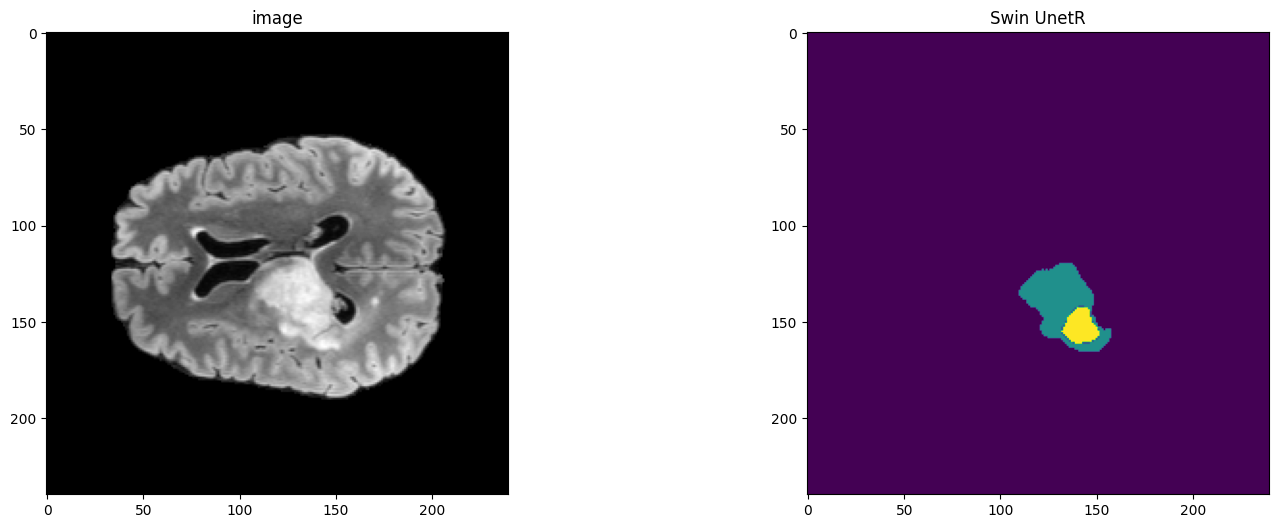

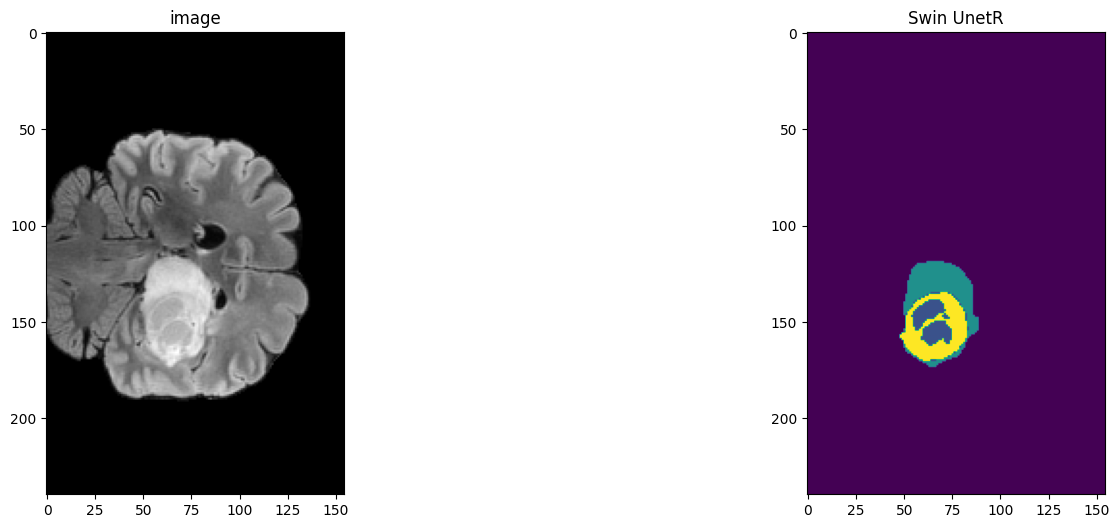

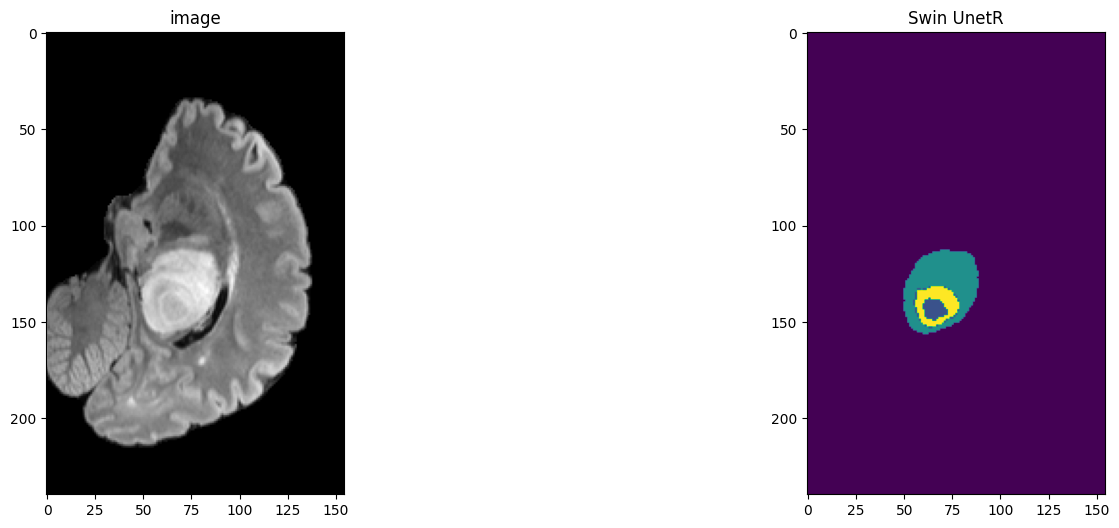

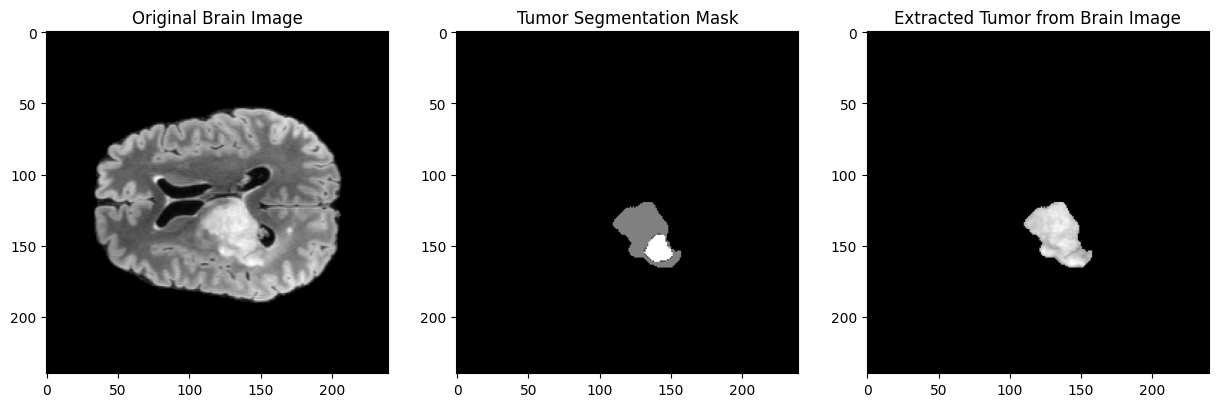

/tmp/ipykernel_34/4033578128.py:153: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  output_image = output_image.resize((240, 240), Image.ANTIALIAS)


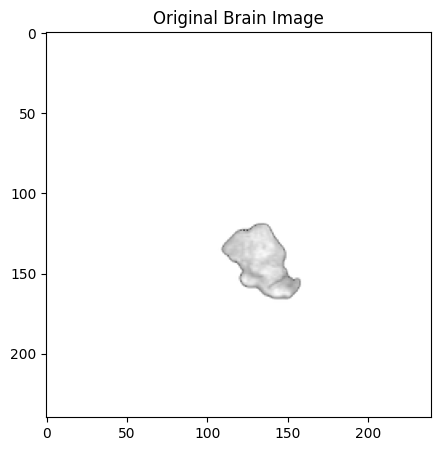

Processed and resized image saved successfully: /kaggle/working/tumor_extracted_f.png
Model loaded successfully.
Input data loaded successfully.
Predictions for new data:
[1]
Prediction for sample 1: HGG


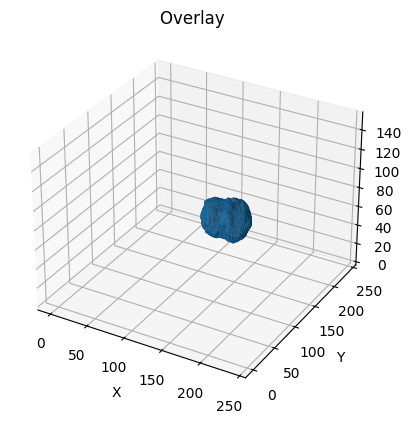

In [32]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai.transforms import Compose, LoadImaged, NormalizeIntensityd
from monai.data import Dataset, DataLoader
#from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
import gzip
import einops
import rembg
import pandas as pd
from joblib import load
import cv2
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai.transforms import Compose, LoadImaged, NormalizeIntensityd
from monai.data import Dataset, DataLoader
from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
import gzip
from functools import partial
from PIL import Image
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import pywt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define function to compress NIfTI file to .nii.gz format
def compress_nifti(input_file_path, output_file_path , output_dir):
    img = nib.load(input_file_path)
    output_file_path = output_file_path + ".nii.gz"
    # Use /kaggle/working/ for writing output
    output_file_path = output_dir +'/'+ os.path.basename(output_file_path)

    with gzip.open(output_file_path, 'wb') as f:
        f.write(img.to_bytes())

def check_files(folder_path):
    directory = folder_path 
    directory1 = os.path.basename(folder_path)
    expected_files = {
        os.path.join(directory, f'{directory1}-t2f.nii'),
        os.path.join(directory, f'{directory1}-t2w.nii'),
        os.path.join(directory, f'{directory1}-t1n.nii'),
        os.path.join(directory, f'{directory1}-t1c.nii')
    }    
    files_in_folder = set(os.listdir(folder_path))
    missing_files = expected_files - files_in_folder
    if missing_files:
        for file_name in expected_files:
            input_file_path = os.path.join(folder_path, file_name)
            output_dir = '/kaggle/working/' + directory1
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created folder successfully: {output_dir}")
            else:
                print(f"Folder already exists: {output_dir}")
            output_file_path = os.path.join(output_dir, file_name.split('.')[0])
            print(output_file_path)
            compress_nifti(input_file_path, output_file_path,output_dir)
        return True, None
    else:
        return False, missing_files
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image as grayscale
    img = cv2.resize(img, (240, 240))
    return img

# Function to extract DWT features
def extract_dwt_features(image):
    coeffs = pywt.dwt2(image, 'haar')  # Apply DWT using Haar wavelet
    cA, (cH, cV, cD) = coeffs
    return np.concatenate((cA.flatten(), cH.flatten(), cV.flatten(), cD.flatten()))

# Iterate through each row in the CSV file
def DWT(img_path):
    features = []

    # Preprocess the image
    img = preprocess_image(img_path)
    
    # Extract DWT features
    img_features = extract_dwt_features(img)
    
    # Append the features, image name, and target label to the respective lists
    features.append(img_features)

    
# Convert lists to numpy arrays
    features = np.array(features)
    # Create a DataFrame to store the extracted features along with image names and target labels
    result_df = pd.DataFrame(features)
    result_df.to_csv("/kaggle/working/file.csv", index=False)
def extrextion_tumor(image_path,mask_path):
    brain_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    tumor_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Find contours in the tumor mask
    contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask for the tumor region
    tumor_region_mask = np.zeros_like(tumor_mask)

    # Iterate over each contour and draw it on the tumor region mask
    for contour in contours:
        cv2.drawContours(tumor_region_mask, [contour], -1, (255), thickness=cv2.FILLED)

    # Apply the tumor region mask to the brain image to extract the tumor
    tumor_extracted = cv2.bitwise_and(brain_image, brain_image, mask=tumor_region_mask)

    # Display the original brain image, tumor segmentation mask, and extracted tumor (optional)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(brain_image, cmap="gray")
    plt.title("Original Brain Image")

    plt.subplot(1, 3, 2)
    plt.imshow(tumor_mask, cmap="gray")
    plt.title("Tumor Segmentation Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(tumor_extracted, cmap="gray")
    plt.title("Extracted Tumor from Brain Image")

    plt.show()

    # Save the extracted tumor with the same name in the output directory
    output_path = os.path.join("/kaggle/working/tumor_extracted.png")
    cv2.imwrite(output_path, tumor_extracted)
    input_image = Image.open("/kaggle/working/tumor_extracted.png")

    # Convert PIL image to numpy array
    input_array = np.array(input_image)

    # Use rembg to remove background
    output_array = rembg.remove(input_array)

    # Convert numpy array back to PIL image
    output_image = Image.fromarray(output_array)

    # Resize the image to 240x240 pixels while maintaining aspect ratio
    output_image = output_image.resize((240, 240), Image.ANTIALIAS)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 1, 1)
    plt.imshow(output_image, cmap="gray")
    plt.title("Original Brain Image")
    plt.show()

    # Save the resized output image with a new filename
    output_path = os.path.join("/kaggle/working/tumor_extracted_f.png")
    output_image.save(output_path)


    print(f"Processed and resized image saved successfully: {output_path}")
import pandas as pd
from joblib import load
from mpl_toolkits.mplot3d import Axes3D

def overlay_label_on_image(image, label):
    # Assumes image.shape is (240, 240, 155) and label.shape is (240, 240, 155)
    overlaid_image = np.zeros_like(image)
    
    # Overlay label onto image wherever label is greater than zero
    overlaid_image[label > 0] = label[label > 0]
    
    return overlaid_image
def predict_with_svm_model(input_data_path, model_path):
    # Load the saved SVM model
    loaded_model = load(model_path)
    print("Model loaded successfully.")

    # Load the input data
    input_data = pd.read_csv(input_data_path)
    print("Input data loaded successfully.")
    
    # Prepare the features (assuming input data is similar to training data)
    X_new = input_data  # Assuming similar preprocessing as in training
    
    # Perform prediction using the loaded SVM model
    y_pred_new = loaded_model.predict(X_new)
    
    # Print or use the predictions
    print("Predictions for new data:")
    print(y_pred_new)
    
    # Assuming binary classification: 0 for LGG, 1 for HGG
    for idx, pred in enumerate(y_pred_new):
        if pred == 0:
            result = "LGG"
        else:
            result = "HGG"
        print(f"Prediction for sample {idx + 1}: {result}")
def plot_3d_overlay(image, label):
    overlaid_image = overlay_label_on_image(image, label)
    
    # Plot the 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Display the 3D volume for the current channel
    ax.voxels(overlaid_image)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Overlay ')

    # Show plot
    plt.show()
    
def select_folder():
    folder_path = "/kaggle/input/brats2023-part-2zip/BraTS-GLI-00751-000"  # Update with your dataset folder path
    is_valid, missing_files = check_files(folder_path)
    if is_valid:
        print("All required files are present in the folder.")
        directory = folder_path                                    
        directory1 = os.path.basename(folder_path)
        print(directory1)
        output_dir = '/kaggle/working/' + directory1

        # Load the required data for model inference
        test_files = [
            {
                "image": [ 
                    os.path.join(output_dir+'/'+directory1 + '-t2f.nii.gz'),
                    os.path.join(output_dir+'/'+directory1 + '-t1c.nii.gz'),
                    os.path.join(output_dir+'/'+directory1 + '-t1n.nii.gz'),
                    os.path.join(output_dir+'/'+directory1 + '-t2w.nii.gz'),
                ],
            }
        ]
        # Define the data transformation for inference
        test_transform = Compose([
            LoadImaged(keys=["image"]),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ])
        test_ds = Dataset(data=test_files, transform=test_transform)
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the pre-trained model
        roi = (128, 128, 128)
        model = SwinUNETR(
            img_size=roi,
            in_channels=4,
            out_channels=3,
            feature_size=48,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            dropout_path_rate=0.0,
            use_checkpoint=True,
        )
        model.load_state_dict(torch.load(os.path.join("/kaggle/input/data-nour-85/model100 (3).pt"))["state_dict"])
        model.to(device)
        model.eval()

        # Define the model inference function
        model_inferer_test = partial(
            sliding_window_inference,
            roi_size=[roi[0], roi[1], roi[2]],
            sw_batch_size=1,
            predictor=model,
            overlap=0.6,
        )

        with torch.no_grad():
            for batch_data in test_loader:
                image = batch_data["image"].cuda()
                image_path = test_files[0]["image"][0]
                print(image.shape)
                prob = torch.sigmoid(model_inferer_test(image))
                print(prob.shape)
                seg = prob[0].detach().cpu().numpy()
                seg = (seg > 0.5).astype(np.int8)
                seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
                seg_out[seg[1] == 1] = 2
                seg_out[seg[0] == 1] = 1
                seg_out[seg[2] == 1] = 4
                print(seg_out.shape)
                image_nib = nib.load(image_path)
                image_data = image_nib.get_fdata()
                # Display the segmentation result
                plt.figure("check", (18, 6))
                plt.subplot(1, 2, 1)
                plt.title(f"image")
                plt.imshow(image_data[:, :, 80], cmap="gray")  # Assuming 80 is the slice number
                plt.subplot(1, 2, 2)
                plt.title(f"Swin UnetR")
                plt.imshow(seg_out[ :, :, 80])   # Assuming 80 is the slice number
                plt.imsave("/kaggle/working/crop_image_3d.png", seg_out[:, :, 80], cmap="gray")
                plt.imsave("/kaggle/working/image_3d.png", image_data[:, :, 80], cmap="gray")
                plt.imsave("/kaggle/working/crop_image_color_3d.png", seg_out[:, :, 80])
                plt.imsave("/kaggle/working/image_color_3d.png", image_data[:, :, 80])
                plt.show()
                
                plt.figure("check", (18, 6))
                plt.subplot(1, 2, 1)
                plt.title(f"image")
                plt.imshow(image_data[:, 140, :], cmap="gray")  # Assuming 80 is the slice number
                plt.subplot(1, 2, 2)
                plt.title(f"Swin UnetR")
                plt.imshow(seg_out[ :, 140, :])   # Assuming 80 is the slice number
                plt.imsave("/kaggle/working/crop_2d.png", seg_out[ :, 140, :], cmap="gray")
                plt.imsave("/kaggle/working/image_d2.png", image_data[:, 140, :], cmap="gray")
                plt.imsave("/kaggle/working/crop_color_d2.png", seg_out[ :, 140, :])
                plt.imsave("/kaggle/working/image_color_d2.png", image_data[:, 140, :])
                plt.show()
                
                plt.figure("check", (18, 6))
                plt.subplot(1, 2, 1)
                plt.title(f"image")
                plt.imshow(image_data[140, :, :], cmap="gray")  # Assuming 80 is the slice number
                plt.subplot(1, 2, 2)
                plt.title(f"Swin UnetR")
                plt.imshow(seg_out[ 140, :, :])   # Assuming 80 is the slice number
                plt.imsave("/kaggle/working/crop_1d.png", seg_out[ 140, :, :], cmap="gray")
                plt.imsave("/kaggle/working/image_1d.png", image_data[140,:, :], cmap="gray")
                plt.imsave("/kaggle/working/crop_color_1d.png", seg_out[ 140, :, :])
                plt.imsave("/kaggle/working/image_color_1d.png", image_data[140, :, :])
                plt.show()
                extrextion_tumor("/kaggle/working/image_3d.png","/kaggle/working/crop_image_3d.png")
                DWT("/kaggle/working/tumor_extracted_f.png")
                predict_with_svm_model("/kaggle/working/file.csv","/kaggle/input/dwt-svm/svm_model_best_DWT_SVM.joblib")
                plot_3d_overlay(image_data, seg_out)
               # Iterate over each channel
                


    else:
        print(f"Missing files: {', '.join(missing_files)}")

# Call the select_folder function to start the process
select_folder()


In [25]:
!pip install einops

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 603.6 kB/s eta 0:00:000:00:01


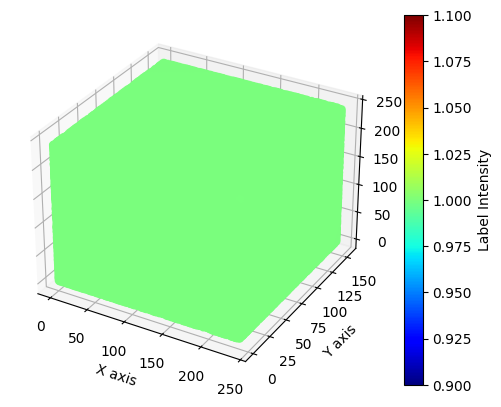

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def overlay_label_on_image(image, label):
    # Assumes image.shape is (240, 240, 155) and label.shape is (240, 240, 155)
    overlaid_image = np.zeros_like(image)
    
    # Overlay label onto image wherever label is greater than zero
    overlaid_image[label > 0] = label[label > 0]
    
    return overlaid_image

def plot_3d_overlay(image, label):
    overlaid_image = overlay_label_on_image(image, label)
    
    # Get the indices of the non-zero elements in the overlaid image
    z, x, y = np.nonzero(overlaid_image)
    values = overlaid_image[z, x, y]
    
    # Plot the 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Use scatter plot to show the points
    scatter = ax.scatter(x, y, z, c=values, cmap='jet', marker='o')
    
    # Add color bar which maps values to colors
    colorbar = fig.colorbar(scatter, ax=ax)
    colorbar.set_label('Label Intensity')
    
    # Set labels
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    plt.show()

# Example usage:
image = np.random.rand(240, 240, 155)  # Example image tensor
label = np.random.randint(0, 2, (240, 240, 155))  # Example label tensor

plot_3d_overlay(image, label)


Enter the dataset folder path:  /kaggle/input/brats2023-part-2zip/BraTS-GLI-00796-000


Folder already exists: ./output/BraTS-GLI-00796-000
Folder already exists: ./output/BraTS-GLI-00796-000
Folder already exists: ./output/BraTS-GLI-00796-000
Folder already exists: ./output/BraTS-GLI-00796-000
All required files are present in the folder.


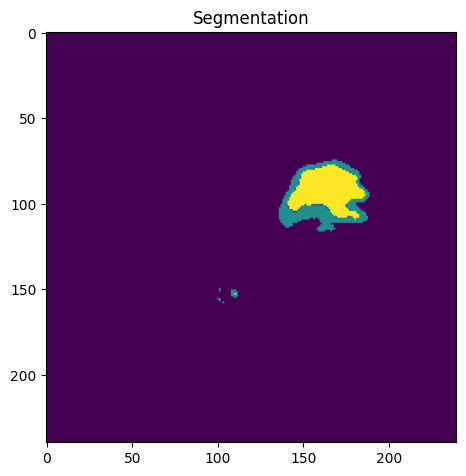

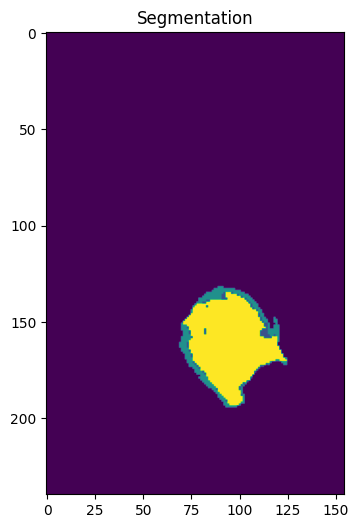

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4 but corresponding boolean dimension is 240

In [13]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai.transforms import Compose, LoadImaged, NormalizeIntensityd
from monai.data import Dataset, DataLoader
from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
import gzip
from functools import partial

def compress_nifti(input_file_path, output_file_path, output_dir):
    img = nib.load(input_file_path)
    output_file_path = output_file_path + ".nii.gz"
    output_file_path = os.path.join(output_dir, os.path.basename(output_file_path))
    with gzip.open(output_file_path, 'wb') as f:
        f.write(img.to_bytes())

def check_files(folder_path):
    directory = folder_path 
    directory1 = os.path.basename(folder_path)
    expected_files = {
        os.path.join(directory, f'{directory1}-t2f.nii'),
        os.path.join(directory, f'{directory1}-t2w.nii'),
        os.path.join(directory, f'{directory1}-t1n.nii'),
        os.path.join(directory, f'{directory1}-t1c.nii')
    }    
    files_in_folder = set(os.listdir(folder_path))
    missing_files = expected_files - files_in_folder
    if missing_files:
        for file_name in expected_files:
            input_file_path = os.path.join(folder_path, file_name)
            output_dir = './output/' + directory1
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created folder successfully: {output_dir}")
            else:
                print(f"Folder already exists: {output_dir}")
            output_file_path = os.path.join(output_dir, file_name.split('.')[0])
            compress_nifti(input_file_path, output_file_path, output_dir)
        return True, None
    else:
        return False, missing_files
def overlay_label_on_image(image, label):
    overlaid_images = []
    for i in range(image.shape[0]):
        overlaid_image = np.zeros_like(image[i])
        # Overlay each label channel onto the corresponding image channel
        for j in range(min(image.shape[0], label.shape[0])):
            overlaid_image[label[j] > 0] = label[j][label[j] > 0]
        overlaid_images.append(overlaid_image)
    return np.stack(overlaid_images)
def select_folder_and_display():
    folder_path = input("Enter the dataset folder path: ")
    is_valid, missing_files = check_files(folder_path)
    if is_valid:
        print("All required files are present in the folder.")
        directory1 = os.path.basename(folder_path)
        output_dir = './output/' + directory1
        import matplotlib.pyplot as plt

        # Load the required data for model inference
        test_files = [{
            "image": [os.path.join(output_dir, f'{directory1}-t2f.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t2w.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t1n.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t1c.nii.gz'),
                      ]}]
        # Define the data transformation for inference
        test_transform = Compose([
            LoadImaged(keys=["image"]),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ])
        test_ds = Dataset(data=test_files, transform=test_transform)
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the pre-trained model
        roi = (128, 128, 128)
        model = SwinUNETR(
            img_size=roi,
            in_channels=4,
            out_channels=3,
            feature_size=48,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            dropout_path_rate=0.0,
            use_checkpoint=True,
        )
        model.load_state_dict(torch.load("/kaggle/input/data-nour-85/model100 (3).pt")["state_dict"])
        model.to(device)
        model.eval()

        # Define the model inference function
        model_inferer_test = partial(
            sliding_window_inference,
            roi_size=[roi[0], roi[1], roi[2]],
            sw_batch_size=1,
            predictor=model,
            overlap=0.6,
        )

        with torch.no_grad():
            for batch_data in test_loader:
                image = batch_data["image"].to(device)
                prob = torch.sigmoid(model_inferer_test(image))
                seg = prob[0].detach().cpu().numpy()
                seg = (seg > 0.5).astype(np.int8)
                seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
                seg_out[seg[1] == 1] = 2
                seg_out[seg[0] == 1] = 1
                seg_out[seg[2] == 1] = 4

                # Display the segmentation result
                plt.figure("Brain Images", (18, 6))
                plt.subplot(1, 3, 3)
                plt.title("Segmentation")
                slice_num = 80
                plt.imshow(seg_out[:, :, slice_num])

                plt.show()
                plt.figure("Brain Images", (18, 6))
                plt.subplot(1, 3, 3)
                plt.title("Segmentation")
                slice_num = 80
                plt.imshow(seg_out[100, :, :])

                plt.show()
                overlaid_seg = overlay_label_on_image(image=image , label=seg)

                
    else:
        print(f"Missing files: {', '.join(missing_files)}")
    
# Call the function to start the process
select_folder_and_display()


In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai.transforms import Compose, LoadImaged, NormalizeIntensityd
from monai.data import Dataset, DataLoader
from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
import gzip
from functools import partial
import ipywidgets as widgets
from IPython.display import display
import ipywidgets as interactive

# Define function to compress NIfTI file to .nii.gz format
def compress_nifti(input_file_path, output_file_path, output_dir):
    img = nib.load(input_file_path)
    output_file_path = output_file_path + ".nii.gz"
    output_file_path = os.path.join(output_dir, os.path.basename(output_file_path))
    with gzip.open(output_file_path, 'wb') as f:
        f.write(img.to_bytes())

def check_files(folder_path):
    directory = folder_path
    directory1 = os.path.basename(folder_path)
    expected_files = {
        os.path.join(directory, f'{directory1}-t2f.nii'),
        os.path.join(directory, f'{directory1}-t2w.nii'),
        os.path.join(directory, f'{directory1}-t1n.nii'),
        os.path.join(directory, f'{directory1}-t1c.nii')
    }
    files_in_folder = set(os.listdir(folder_path))
    missing_files = expected_files - files_in_folder
    if missing_files:
        for file_name in expected_files:
            input_file_path = os.path.join(folder_path, file_name)
            output_dir = './output/' + directory1
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created folder successfully: {output_dir}")
            else:
                print(f"Folder already exists: {output_dir}")
            output_file_path = os.path.join(output_dir, file_name.split('.')[0])
            compress_nifti(input_file_path, output_file_path, output_dir)
        return True, None
    else:
        return False, missing_files

def select_folder_and_display(b):
    folder_path = text.value.strip()
    is_valid, missing_files = check_files(folder_path)
    if is_valid:
        print("All required files are present in the folder.")
        directory1 = os.path.basename(folder_path)
        output_dir = './output/' + directory1

        # Load the required data for model inference
        test_files = [{
            "image": [os.path.join(output_dir, f'{directory1}-t2f.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t2w.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t1n.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t1c.nii.gz'),
                      ]}]
        # Define the data transformation for inference
        test_transform = Compose([
            LoadImaged(keys=["image"]),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ])
        test_ds = Dataset(data=test_files, transform=test_transform)
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the pre-trained model
        roi = (128, 128, 128)
        model = SwinUNETR(
            img_size=roi,
            in_channels=4,
            out_channels=3,
            feature_size=48,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            dropout_path_rate=0.0,
            use_checkpoint=True,
        )
        model.load_state_dict(torch.load("/kaggle/input/data-nour-85/model100 (3).pt")["state_dict"])
        model.to(device)
        model.eval()

        # Define the model inference function
        model_inferer_test = partial(
            sliding_window_inference,
            roi_size=[roi[0], roi[1], roi[2]],
            sw_batch_size=1,
            predictor=model,
            overlap=0.6,
        )

        with torch.no_grad():
            for batch_data in test_loader:
                image = batch_data["image"].to(device)
                prob = torch.sigmoid(model_inferer_test(image))
                seg = prob[0].detach().cpu().numpy()
                seg = (seg > 0.5).astype(np.int8)
                seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
                seg_out[seg[1] == 1] = 2
                seg_out[seg[0] == 1] = 1
                seg_out[seg[2] == 1] = 4

                # Display the segmentation result
                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 3)
                plt.title("Segmentation")
                slice_num = 80
                plt.imshow(seg_out[:, :, slice_num])
                plt.show()

                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 3)
                plt.title("Segmentation")
                slice_num = 80
                plt.imshow(seg_out[100, :, :])
                plt.show()
                interactive_plot = interact(show_slice, i=(0, seg_out.shape[2]-1))
                output = interactive_plot.children[-1]
                output.layout.height = '350px'
                interactive_plot
                # Save the plot as an image file
                plt.savefig(os.path.join('/kaggle/working', 'segmentation_result.png'))

    else:
        print(f"Missing files: {', '.join(missing_files)}")
def show_slice(i):
    plt.imshow(array[:,:,i], cmap='gray')
    plt.show()
# Create input widget
text = widgets.Text(
    value='',
    placeholder='Enter folder path',
    description='Path:',
    disabled=False
)

# Create button widget
button = widgets.Button(description="Load and Display")
button.on_click(select_folder_and_display)

# Display widgets
display(text)
display(button)


Text(value='', description='Path:', placeholder='Enter folder path')

Button(description='Load and Display', style=ButtonStyle())

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from monai.transforms import Compose, LoadImaged, NormalizeIntensityd
from monai.data import Dataset, DataLoader
from monai.networks.nets import SwinUNETR
from monai.inferers import sliding_window_inference
import gzip
from functools import partial
import ipywidgets as widgets
from IPython.display import display

# Define function to compress NIfTI file to .nii.gz format
def compress_nifti(input_file_path, output_file_path, output_dir):
    img = nib.load(input_file_path)
    output_file_path = output_file_path + ".nii.gz"
    output_file_path = os.path.join(output_dir, os.path.basename(output_file_path))
    with gzip.open(output_file_path, 'wb') as f:
        f.write(img.to_bytes())

def check_files(folder_path):
    directory = folder_path
    directory1 = os.path.basename(folder_path)
    expected_files = {
        os.path.join(directory, f'{directory1}-t2f.nii'),
        os.path.join(directory, f'{directory1}-t2w.nii'),
        os.path.join(directory, f'{directory1}-t1n.nii'),
        os.path.join(directory, f'{directory1}-t1c.nii')
    }
    files_in_folder = set(os.listdir(folder_path))
    missing_files = expected_files - files_in_folder
    if missing_files:
        for file_name in expected_files:
            input_file_path = os.path.join(folder_path, file_name)
            output_dir = './output/' + directory1
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print(f"Created folder successfully: {output_dir}")
            else:
                print(f"Folder already exists: {output_dir}")
            output_file_path = os.path.join(output_dir, file_name.split('.')[0])
            compress_nifti(input_file_path, output_file_path, output_dir)
        return True, None
    else:
        return False, missing_files

def select_folder_and_display(b):
    folder_path = text.value.strip()
    is_valid, missing_files = check_files(folder_path)
    if is_valid:
        print("All required files are present in the folder.")
        directory1 = os.path.basename(folder_path)
        output_dir = './output/' + directory1

        # Load the required data for model inference
        test_files = [{
            "image": [os.path.join(output_dir, f'{directory1}-t2f.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t2w.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t1n.nii.gz'),
                      os.path.join(output_dir, f'{directory1}-t1c.nii.gz'),
                      ]}]
        # Define the data transformation for inference
        test_transform = Compose([
            LoadImaged(keys=["image"]),
            NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ])
        test_ds = Dataset(data=test_files, transform=test_transform)
        test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load the pre-trained model
        roi = (128, 128, 128)
        model = SwinUNETR(
            img_size=roi,
            in_channels=4,
            out_channels=3,
            feature_size=48,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            dropout_path_rate=0.0,
            use_checkpoint=True,
        )
        model.load_state_dict(torch.load("/kaggle/input/data-nour-85/model100 (3).pt")["state_dict"])
        model.to(device)
        model.eval()

        # Define the model inference function
        model_inferer_test = partial(
            sliding_window_inference,
            roi_size=[roi[0], roi[1], roi[2]],
            sw_batch_size=1,
            predictor=model,
            overlap=0.6,
        )

        with torch.no_grad():
            for batch_data in test_loader:
                image = batch_data["image"].to(device)
                prob = torch.sigmoid(model_inferer_test(image))
                seg = prob[0].detach().cpu().numpy()
                seg = (seg > 0.5).astype(np.int8)
                seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
                seg_out[seg[1] == 1] = 2
                seg_out[seg[0] == 1] = 1
                seg_out[seg[2] == 1] = 4

                # Display the segmentation result
                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 3)
                plt.title("Segmentation")
                slice_num = 80
                plt.imshow(seg_out[:, :, slice_num])
                plt.show()

                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 3)
                plt.title("Segmentation")
                slice_num = 80
                plt.imshow(seg_out[100, :, :])
                plt.show()
                
                # Save the plot as an image file
                plt.savefig(os.path.join('/kaggle/working', 'segmentation_result.png'))

    else:
        print(f"Missing files: {', '.join(missing_files)}")

# Create input widget
text = widgets.Text(
    value='',
    placeholder='Enter folder path',
    description='Path:',
    disabled=False
)

# Create button widget
button = widgets.Button(description="Load and Display")
button.on_click(select_folder_and_display)

# Display widgets
display(text)
display(button)


Text(value='', description='Path:', placeholder='Enter folder path')

Button(description='Load and Display', style=ButtonStyle())